In [1]:
# Import and creating some helper functions
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model


def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array):
    """
    Adds random noise to each image in the supplied array.
    """

    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc=0.0, scale=1.0, size=array.shape
    )

    return np.clip(noisy_array, 0.0, 1.0)


def display(array1, array2):
    """
    Displays ten random images from each one of the supplied arrays.
    """

    n = 10

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()

1. Load and preprocess our MNIST Dataset


We then create a noisy version of our training and test data

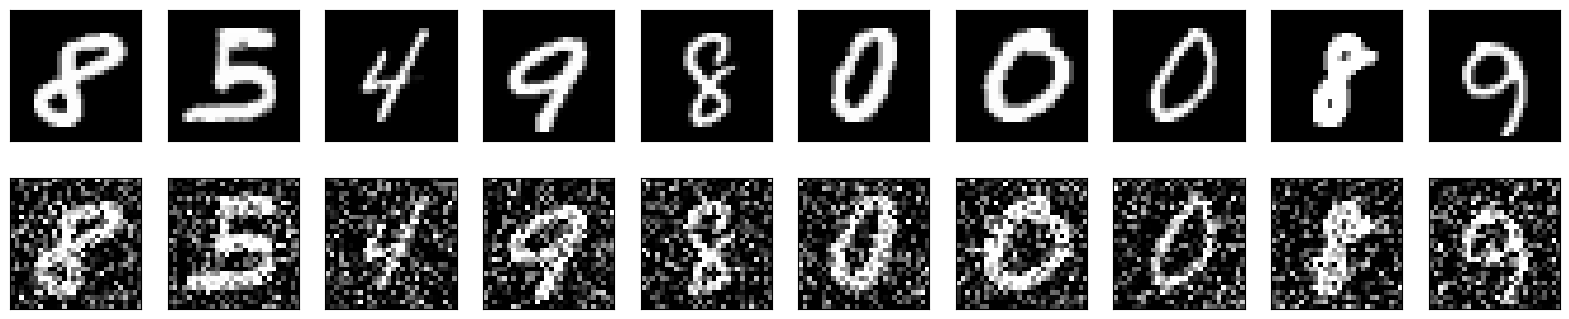

In [6]:
# Since we only need images from the dataset to encode and decode, we
# won't use the labels.
(train_data, _), (test_data, _) = mnist.load_data()

# Normalize and reshape the data
train_data = preprocess(train_data)
test_data = preprocess(test_data)

# Create a copy of the data with added noise
noisy_train_data = noise(train_data)
noisy_test_data = noise(test_data)

# Display the train data and a version of it with added noise
display(train_data, noisy_train_data)

2. Now let's also create our autoencoder
model **bold text**

We are going to use the Functional API to build our convolutional autoencoder (this should be familar to PyTorch users).

In [7]:
# Our input shape is 28 x 28 x 1
input = layers.Input(shape=(28, 28, 1))

# The Encoder Model
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# The Decoder Model
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder - Note it is the entire concatenation of the encoder and decoder
autoencoder = Model(input, x)

autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 14, 14, 32)        9248

**3. Train our autoencode**

We will train our autoencoder using train_data as both our input data and target.

NOTE: We are setting up the validation data using the same format.

In [8]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    epochs= 10,
    batch_size=128,
    shuffle=True,
    validation_data=(test_data, test_data),
)

Epoch 1/10
469/469 [==============================] - 119s 244ms/step - loss: 0.1281 - val_loss: 0.0735
Epoch 2/10
469/469 [==============================] - 107s 227ms/step - loss: 0.0720 - val_loss: 0.0698
Epoch 3/10
469/469 [==============================] - 109s 232ms/step - loss: 0.0696 - val_loss: 0.0684
Epoch 4/10
469/469 [==============================] - 106s 226ms/step - loss: 0.0684 - val_loss: 0.0674
Epoch 5/10
469/469 [==============================] - 105s 224ms/step - loss: 0.0676 - val_loss: 0.0668
Epoch 6/10
469/469 [==============================] - 107s 229ms/step - loss: 0.0670 - val_loss: 0.0663
Epoch 7/10
469/469 [==============================] - 107s 228ms/step - loss: 0.0666 - val_loss: 0.0659
Epoch 8/10
469/469 [==============================] - 107s 228ms/step - loss: 0.0661 - val_loss: 0.0655
Epoch 9/10
469/469 [==============================] - 106s 226ms/step - loss: 0.0658 - val_loss: 0.0653
Epoch 10/10
469/469 [==============================] - 105s 225m

4. Get our Autoencoder Predictions


Now we'll predict on our test dataset and display the original image together with the prediction from our autoencoder.

Notice how close the predictions are to the original image. However if you look closely you can see slight differences.

313/313 [==============================] - 6s 19ms/step


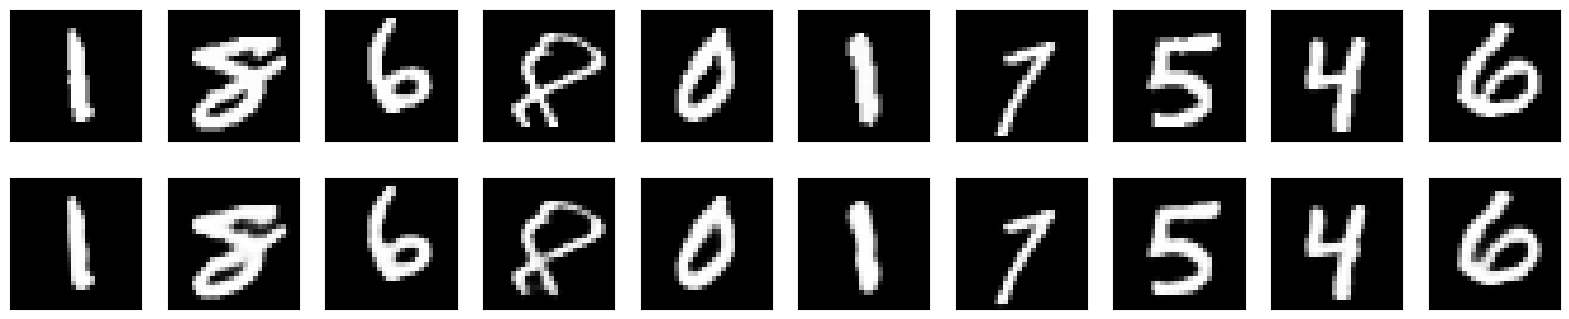

In [9]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

5. Now let's use our Autoencoder as a Denoiser

To do this we'll retrain it using the noisy data as our input and the clean data as our target. This teaches our autoencoder to learn how to denoise the images.

In [10]:
autoencoder.fit(
    x=noisy_train_data,
    y=train_data,
    epochs=10,
    batch_size=128,
    shuffle=True,
    validation_data=(noisy_test_data, test_data),
)

Epoch 1/10
469/469 [==============================] - 113s 242ms/step - loss: 0.1016 - val_loss: 0.0937
Epoch 2/10
469/469 [==============================] - 113s 241ms/step - loss: 0.0932 - val_loss: 0.0916
Epoch 3/10
469/469 [==============================] - 113s 241ms/step - loss: 0.0915 - val_loss: 0.0903
Epoch 4/10
469/469 [==============================] - 112s 239ms/step - loss: 0.0905 - val_loss: 0.0895
Epoch 5/10
469/469 [==============================] - 109s 233ms/step - loss: 0.0898 - val_loss: 0.0888
Epoch 6/10
469/469 [==============================] - 111s 237ms/step - loss: 0.0891 - val_loss: 0.0885
Epoch 7/10
469/469 [==============================] - 110s 234ms/step - loss: 0.0885 - val_loss: 0.0878
Epoch 8/10
469/469 [==============================] - 111s 237ms/step - loss: 0.0881 - val_loss: 0.0874
Epoch 9/10
469/469 [==============================] - 109s 233ms/step - loss: 0.0877 - val_loss: 0.0872
Epoch 10/10
469/469 [==============================] - 110s 236m

6. Now let's evaluate it's performance on our noisy Test Data


313/313 [==============================] - 5s 16ms/step


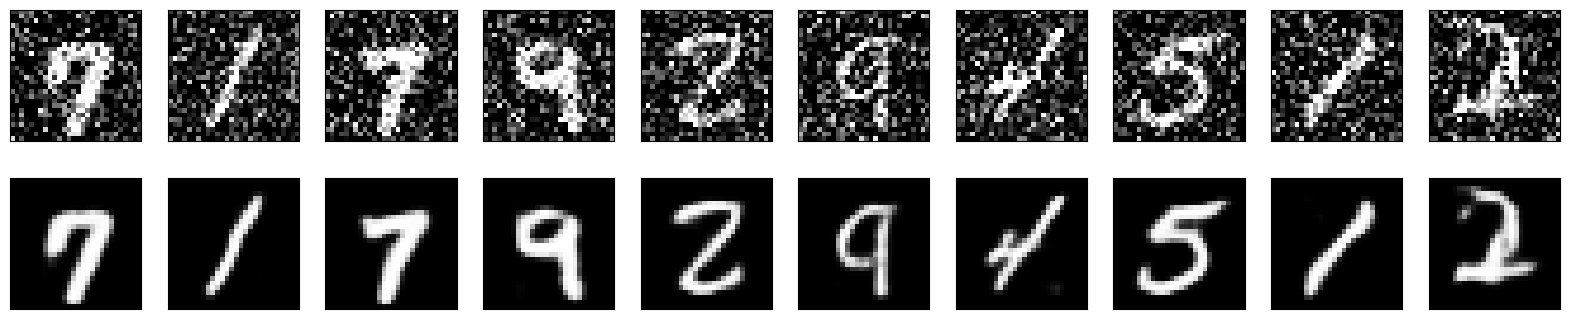

In [11]:
predictions = autoencoder.predict(noisy_test_data)
display(noisy_test_data, predictions)